In [5]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,LSTM,TimeDistributed,Dense,Flatten,Dropout,RepeatVector,GRU,Bidirectional,Permute
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kerastuner as kt
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from keras_preprocessing import sequence
from tensorflow.python.keras.layers import Concatenate,concatenate,Activation, dot

import os

filename='pre_data_dl.xlsx'
data_dl=pd.read_excel(filename)
pd.set_option('display.max_columns', None)
print(data_dl.head())

filename1='pre_data_dl_aug1.xlsx'
filename2='pre_data_dl_aug2.xlsx'

data_dl_aug1=pd.read_excel(filename1)
pd.set_option('display.max_columns', None)
print(data_dl_aug1.head())

data_dl_aug2=pd.read_excel(filename2)
print(data_dl_aug2.head())

X = (data_dl["Combined Description Cleaned"])
y= (data_dl['Assignment group'])

#categorical encoding y
y=pd.get_dummies(data_dl['Assignment group'])
  

#parameters
max_features=10000
emb_dim=300
batch_size=1024
epochs=10
out_dim=74

   Unnamed: 0  Unnamed: 0.1  \
0           0             0   
1           1             1   
2           2             2   
3           3             3   
4           4             4   

                        Combined Description Cleaned Assignment group  
0  login issue user manager name checked the name...            GRP_0  
1  outlook received from hello team my are not in...            GRP_0  
2    cannot log in to received from   cannot on best            GRP_0  
3                         unable to access tool page            GRP_0  
4                                              error            GRP_0  
   Unnamed: 0                       Combined Description Cleaned  \
0           0  login issue user manager name checked the name...   
1           1  outlook received from hello team my are not in...   
2           2  cannot log in to received from hi i cannot on ...   
3           3                         unable to access tool page   
4           4                            

In [6]:
#function for tokenizer
def dfTokenizer(df):
 tokenizer=Tokenizer(num_words=max_features,char_level=False)
 tokenizer.fit_on_texts(df)
 sequences=tokenizer.texts_to_sequences(df)
 return sequences,tokenizer
#tokenization
X,tokenizer = dfTokenizer(data_dl["Combined Description Cleaned"]) 
vocab_size=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size)

#function for padding
def pad(x, length=None):
 if length is None:
   length=max([len(sentence)  for sentence in x])
 return pad_sequences(x,maxlen=length,padding='post')
 
 #padding 
X=pad_sequences(X,padding='post')


#function for splitting the data
def split(X,y):
 X_train_spl,X_test_spl,y_train_spl,y_test_spl=train_test_split(X,y,test_size=0.2,random_state=123)
 return X_train_spl,X_test_spl,y_train_spl,y_test_spl
#split the data
X_train,X_test,y_train,y_test=split(X,y)


#configuring the callback
early_stopping =  EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    min_delta=0.01, 
    mode='max'
)


#function for plotting accuracy,loss
def plot(model,history):
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 epochs = range(1, len(acc) + 1)
 plt.plot(epochs, acc, 'bo', label='Training acc')
 plt.plot(epochs, val_acc, 'b', label='Validation acc')
 plt.title( ' Training and validation accuracy')
 plt.legend()
 plt.figure()
 plt.plot(epochs, loss, 'bo', label='Training loss')
 plt.plot(epochs, val_loss, 'b', label='Validation loss')
 plt.title('Training and validation loss')
 plt.legend()
 plt.show()
 return 

vocabulary size is:  3316


In [7]:
inp_len=X.shape[1]
inputs = Input(shape=(inp_len,))

def TRANSFORMER_model(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(Bidirectional(LSTM(64, return_sequences=False)))
 model.add(Dropout(0.2))
 model.add(RepeatVector(64))
 model.add(Bidirectional(LSTM(64, return_sequences=True)))
 model.add(TimeDistributed(Dense(units = 64, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])   
 model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
 return model

In [8]:
#customising the kerastuner function to include batch size and epochs
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
     kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 256, 512,step=256 )
     kwargs['epochs'] = trial.hyperparameters.Int('epochs', 5, 10,20)
     super(MyTuner, self).run_trial(trial, *args, **kwargs)

Trial 10 Complete [00h 11m 55s]
val_accuracy: 0.608132004737854

Best val_accuracy So Far: 0.6199175119400024
Total elapsed time: 01h 55m 46s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/5A\untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
epochs: 5
Score: 0.6199175119400024
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
epochs: 5
Score: 0.6116676330566406
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
epochs: 5
Score: 0.608132004737854
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
epochs: 5
Score: 0.6040070652961731
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
epochs: 5
Score: 0.6040070652961731
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Emb

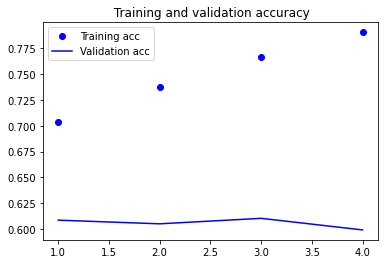

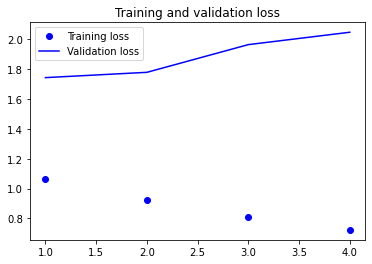

Accuracy of TRANSFORMER for unaugmented data is : 59.92928743362427
Validation Accuracy of TRANSFORMER for unagumented data is: 82.45872855186462
Mean loss of  Validation data of TRANSFORMER for unaugmented data is : 1.8842289447784424
Mean loss of  Training data of TRANSFORMER for unaugmented data is : 0.8790939748287201


In [9]:
        
tuner =MyTuner(
    TRANSFORMER_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/5A"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_TRANSFORMER = tuner.get_best_models()[0]
print("Hyperparameters for TRANSFORMER are",best_model_TRANSFORMER)


modelname="TRANSFORMERModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_TRANSFORMER.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_TRANSFORMER,history)

scores_TRANSFORMER =best_model_TRANSFORMER.evaluate(X_test, y_test, verbose=0)
scores_TRANSFORMER_val = best_model_TRANSFORMER.evaluate(X_train, y_train, verbose=0)
print("Accuracy of TRANSFORMER for unaugmented data is :", (scores_TRANSFORMER[1]*100))
print("Validation Accuracy of TRANSFORMER for unagumented data is:", (scores_TRANSFORMER_val[1]*100))
#print("Validation Accuracy of TRANSFORMER for unagumented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of TRANSFORMER for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of TRANSFORMER for unaugmented data is :",np.array(history.history['loss']).mean())        

In [10]:
X_aug1 = (data_dl_aug1["Combined Description Cleaned"])
y_aug1= (data_dl_aug1['Assignment group'])

#categorical encoding y
y_aug1=pd.get_dummies(data_dl_aug2['Assignment group'])


X_aug2 = (data_dl_aug2["Combined Description Cleaned"])
y_aug2= (data_dl_aug2['Assignment group'])

In [11]:
#categorical encoding y
y_aug2=pd.get_dummies(data_dl_aug2['Assignment group'])

#tokenization
X_aug1,tokenizer = dfTokenizer(data_dl_aug1["Combined Description Cleaned"]) 
vocab_size_aug1=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size_aug1)

X_aug2,tokenizer = dfTokenizer(data_dl_aug2["Combined Description Cleaned"]) 
vocab_size_aug2=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size_aug2)

vocabulary size is:  3956
vocabulary size is:  4424


In [12]:
#padding
X_aug1=pad_sequences(X_aug1,padding='post')
X_aug2=pad_sequences(X_aug2,padding='post')
y_aug1=y_aug1[0:17586]

In [13]:
#split the data.Only augmented data is split using stratify
def split_stratify(X,y):
 X_train_spl,X_test_spl,y_train_spl,y_test_spl=train_test_split(X,y,test_size=0.2,stratify=y,random_state=123)
 return X_train_spl,X_test_spl,y_train_spl,y_test_spl

X_train_aug1,X_test_aug1,y_train_aug1,y_test_aug1=split_stratify(X_aug1,y_aug1)
X_train_aug2,X_test_aug2,y_train_aug2,y_test_aug2=split_stratify(X_aug2,y_aug2)


inp_len1=X_aug1.shape[1]
print(inp_len1)

191


Trial 10 Complete [00h 29m 36s]
val_accuracy: 0.728823184967041

Best val_accuracy So Far: 0.7387720346450806
Total elapsed time: 04h 50m 35s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/7p\untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
Score: 0.7387720346450806
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
Score: 0.7353609800338745
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
Score: 0.7350767254829407
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
Score: 0.7339397668838501
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
Score: 0.7319499850273132
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed

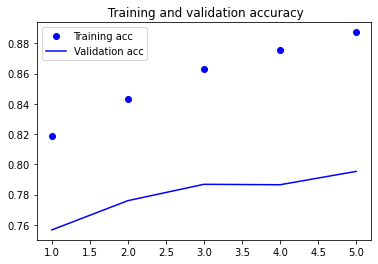

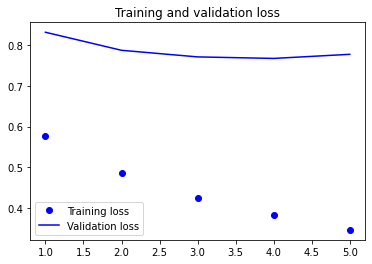

Accuracy of TRANSFORMER for level1 augmented data is : 79.53382730484009
Validation Accuracy of TRANSFORMER for level1 augmented data is: 91.72590374946594
Mean loss of  Validation data of TRANSFORMER for level1 augmented data is : 0.7868643522262573
Mean loss of  training data of TRANSFORMER for level1 augmented data is : 0.44390264749526975


In [14]:
def TRANSFORMER_model1(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(Bidirectional(LSTM(64, return_sequences=False)))
 model.add(Dropout(0.2))
 model.add(RepeatVector(64))
 model.add(Bidirectional(LSTM(64, return_sequences=True)))
 model.add(TimeDistributed(Dense(units = 64, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])   
 model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
 return model

tuner =MyTuner(
    TRANSFORMER_model1,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/7p"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_TRANSFORMER = tuner.get_best_models()[0]
print("Hyperparameters for TRANSFORMER are",best_model_TRANSFORMER)


modelname="TRANSFORMERModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_TRANSFORMER.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_TRANSFORMER,history)

scores_TRANSFORMER_aug1 =best_model_TRANSFORMER.evaluate(X_test_aug1, y_test_aug1, verbose=0)
scores_TRANSFORMER_val_aug1 = best_model_TRANSFORMER.evaluate(X_train_aug1, y_train_aug1, verbose=0)
print("Accuracy of TRANSFORMER for level1 augmented data is :", (scores_TRANSFORMER_aug1[1]*100))
print("Validation Accuracy of TRANSFORMER for level1 augmented data is:", (scores_TRANSFORMER_val_aug1[1]*100))
#print("Validation Accuracy of TRANSFORMER for level1 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of TRANSFORMER for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of TRANSFORMER for level1 augmented data is :",np.array(history.history['loss']).mean())

Trial 10 Complete [00h 59m 08s]
val_accuracy: 0.835548460483551

Best val_accuracy So Far: 0.8397117853164673
Total elapsed time: 09h 51m 47s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/7k\untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
Score: 0.8397117853164673
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
epochs: 5
Score: 0.835548460483551
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
epochs: 5
Score: 0.8349079489707947
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
Score: 0.8345876932144165
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
Score: 0.8313851356506348
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding 

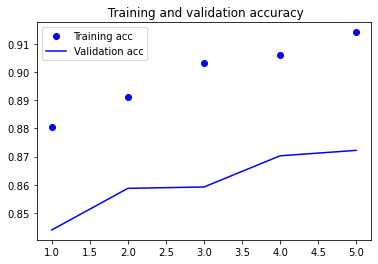

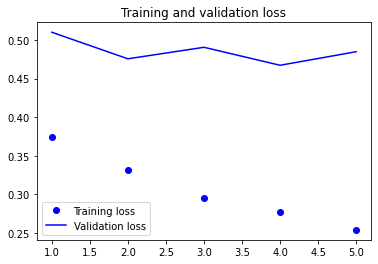

Accuracy of TRANSFORMER for level2 augmented data is : 87.22177743911743
Validation Accuracy of TRANSFORMER for level2 augmented data is: 93.70996356010437
Mean loss of  Validation data of TRANSFORMER for level2 augmented data is : 0.4855508625507355
Mean loss of  training data of TRANSFORMER for level2 augmented data is : 0.3065550744533539


In [15]:
tuner =MyTuner(
    TRANSFORMER_model1,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/7k"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_TRANSFORMER = tuner.get_best_models()[0]
print("Hyperparameters for TRANSFORMER are",best_model_TRANSFORMER)


modelname="TRANSFORMERModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_TRANSFORMER.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_TRANSFORMER,history)

scores_TRANSFORMER_aug2 =best_model_TRANSFORMER.evaluate(X_test_aug2, y_test_aug2, verbose=0)
scores_TRANSFORMER_val_aug2 = best_model_TRANSFORMER.evaluate(X_train_aug2, y_train_aug2, verbose=0)
print("Accuracy of TRANSFORMER for level2 augmented data is :", (scores_TRANSFORMER_aug2[1]*100))
print("Validation Accuracy of TRANSFORMER for level2 augmented data is:", (scores_TRANSFORMER_val_aug2[1]*100))
#print("Validation Accuracy of TRANSFORMER for level2 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of TRANSFORMER for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of TRANSFORMER for level2 augmented data is :",np.array(history.history['loss']).mean())

In [17]:
print("Accuracy of ENCODER DECODER without attention with hyperparameter tuning unagumented data is:", (scores_TRANSFORMER[1]*100))
print("Accuracy of ENCODER DECODER without attention with hyperparameter tuning for level1 augmentation data is:", (scores_TRANSFORMER_aug1[1]*100))
print("Accuracy of ENCODER DECODER without attention with hyperparameter tuning for level2 augmentation data is:", (scores_TRANSFORMER_aug2[1]*100))                                                                                                    

Accuracy of ENCODER DECODER without attention with hyperparameter tuning unagumented data is: 59.92928743362427
Accuracy of ENCODER DECODER without attention with hyperparameter tuning for level1 augmentation data is: 79.53382730484009
Accuracy of ENCODER DECODER without attention with hyperparameter tuning for level2 augmentation data is: 87.22177743911743
